In [1]:
import re
import os
import random
import gensim
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from konlpy.tag import Mecab
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

# 0. 사전 설치

> 본 프로젝트에서 문장 토큰화에 사용하는 한국어 형태소 분석기 Mecab을 사용하려면 아래와 같이 사전 설치가 필요하다.<br>
> [출처 : KoNLPy 가이드](https://konlpy.org/en/latest/install/)<br>
> <br>
> 실험 환경이 Jupyter notebook에서 진행된다면 아래 링크의 설치 가이드를 추가로 진행해주어야 한다.<br>
> [출처 : 주피터에서 mecab 설치법](https://bangseogs.tistory.com/89)

# 1. Korean Data Load

> 본 1장에서는 챗봇 모델에 활용할 데이터를 메모리에 적재하고 데이터의 구성 정보를 확인하는 과정을 기술한다.<br>
> 해당 데이터는 이별과 관련된 주제로 개설된 '사랑보다 아름다운 실연' Daum 카페로부터 이별 관련 한국어 데이터 11,823개을 활용한다.<br>
> <br>
> [출처 - songys/Chatbot_data](https://github.com/songys/Chatbot_data)

In [2]:
korean_data = pd.read_csv(os.getenv('HOME') + '/aiffel/transformer_chatbot/data/ChatbotData .csv')
korean_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


> 불러온 데이터를 확인한 결과 아래와 같은 정보를 획득했다.<br>
> 1. Q(질문) - 다음 카페 질문 게시글 제목 데이터이다.<br>
> 2. A(답변) - 게시글의 답변 데이터이다.<br>
> 3. Label - 어떤 의미가 담긴 정보인지 불명.<br>

> 데이터의 총 개수는 11,823개이다.

> 의미없는 정보인 'label' 데이터는 삭제한다.

In [3]:
del korean_data['label']

# 2. Data Analysis

> 본 2 장에서는 Chat-Bot 모델에 활용할 데이터를 분석하는 과정을 기술한다.<br>
> 데이터 분석 과정에서는 데이터 정보 확인, 결측치 확인, 중복 데이터 확인, 문장 길이 분포 확인 작업이 진행된다.

## 2.1 Check Dataset Info

> <code>pandas.DataFrame.info()</code>을 활용하여 한국어 데이터 내 <code>questions</code>, <code>answers</code>의 구성 정보를 확인한다.

In [4]:
korean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
dtypes: object(2)
memory usage: 184.9+ KB


## 2.2 Check Dataset Deduplication

> <code>questions</code>, <code>answers</code> 데이터는 중복되는 데이터가 없도록 중복을 제거하는 작업을 진행한다.

In [5]:
korean_data.drop_duplicates(inplace=True)

In [6]:
korean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11750 entries, 0 to 11822
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11750 non-null  object
 1   A       11750 non-null  object
dtypes: object(2)
memory usage: 275.4+ KB


> 중복 데이터를 제거한 <code>questions</code>, <code>answers</code> 데이터는 기존 11,823 개에서 11,750 개로 감소되며, 73개의 중복 데이터가 제거되었음을 확인할 수 있다.

# 3. Data preprocessing

> 2장에서 진행한 데이터 분석 결과를 바탕으로 데이터를 전처리하는 과정을 진행한다.<br>
> 데이터 전처리는 모델에 사용하기위해 정규식을 활용한 문장 정제, 문장 토큰화 작업을 진행한다.

## 3.1 정규식을 활용한 문장 정제

> 모델이 자연어를 학습함에 있어서 특수문자는 불필요한 노이즈로 작용하므로, 규칙 내 특수 문자와 국문-영문에 해당하지 않는 문자를 제거 후 공백으로 처리한다.

In [7]:
def preprocess_sentence(sentence, decoder=False):
    
    # list의 []는 공백처리
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    # 영문의 경우 소문자로 변환 후 좌우 공백 제거
    sentence = sentence.lower().strip()
    
    # 문장 부호 이외 다른 특수문자 제거
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    
    # 영문자, 한글, 숫자, 주요 특수문자 이외 모든 문자는 공백처리
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣0-9?.!,]+", " ", sentence)
    
    # 단어 좌우 공백 제거
    sentence = sentence.strip()
    
    if decoder:
        sentence = "<start> " + sentence + " <end>"

    return sentence

In [8]:
korean_data['Q'] = korean_data['Q'].apply(lambda x: preprocess_sentence(x, decoder=False))
korean_data['A'] = korean_data['A'].apply(lambda x: preprocess_sentence(x, decoder=False))

In [9]:
korean_data[:5]

,Q,A
0,12시 땡 !,하루가 또 가네요 .
1,1지망 학교 떨어졌어,위로해 드립니다 .
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .
4,ppl 심하네,눈살이 찌푸려지죠 .


## 3.2 형태소 기반 문장 분할

> <code>Mecab()</code>을 활용하여 문장내 문자를 형태소로 분할하는 작업을 진행한다.

In [10]:
m = Mecab()
korean_data["Q"] = korean_data["Q"].apply(lambda x: " ".join(m.morphs(x)))
korean_data["A"] = korean_data["A"].apply(lambda x: " ".join(m.morphs(x)))

In [11]:
korean_data[:5]

,Q,A
0,12 시 땡 !,하루 가 또 가 네요 .
1,1 지망 학교 떨어졌 어,위로 해 드립니다 .
2,3 박 4 일 놀 러 가 고 싶 다,여행 은 언제나 좋 죠 .
3,3 박 4 일 정도 놀 러 가 고 싶 다,여행 은 언제나 좋 죠 .
4,ppl 심하 네,눈살 이 찌푸려 지 죠 .


> 디코더 문장 양 끝에 start, end 토큰을 추가한다.

In [12]:
korean_data['A'] = korean_data['A'].apply(lambda x: preprocess_sentence(x, decoder=True))

korean_data[:5]

,Q,A
0,12 시 땡 !,<start> 하루 가 또 가 네요 . <end>
1,1 지망 학교 떨어졌 어,<start> 위로 해 드립니다 . <end>
2,3 박 4 일 놀 러 가 고 싶 다,<start> 여행 은 언제나 좋 죠 . <end>
3,3 박 4 일 정도 놀 러 가 고 싶 다,<start> 여행 은 언제나 좋 죠 . <end>
4,ppl 심하 네,<start> 눈살 이 찌푸려 지 죠 . <end>


## 3.3 Tokenizer

> Chat-Bot 모델에 활용할 데이터를 Mecab 클래스를 활용하여 형태소 단위로 토큰화하는 함수를 구현 및 토큰화를 진행한다.

In [13]:
def create_tokenizer(df_data):
    # step1. tokenizer 인스턴스 객체 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',oov_token="<UNK>")
    
    # step2. tokenizer 객체 훈련
    sentence_input = [sentence.split() for sentence in df_data]
    tokenizer.fit_on_texts(sentence_input)
    
    return tokenizer

In [14]:
df_data = pd.concat([korean_data["Q"], korean_data["A"]])
tokenizer = create_tokenizer(df_data)

In [15]:
print(f"tokenizer의 토큰 개수: {len(tokenizer.word_index)} 개")

tokenizer의 토큰 개수: 6831 개


## 3.4 Sentence Sequences

In [16]:
def sentence_sentence(df_data, tokenizer):
    tensor = tokenizer.texts_to_sequences(df_data)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor

In [17]:
enc_tensor = sentence_sentence(korean_data["Q"], tokenizer)
dec_tensor = sentence_sentence(korean_data["A"], tokenizer)

In [18]:
print(enc_tensor.shape)
print(dec_tensor.shape)

(11750, 32)
(11750, 42)


## 3.5 Get Test Data

In [19]:
test_data = korean_data[:100]
korean_data = korean_data[100:]

In [20]:
test_data[:5]

,Q,A
0,12 시 땡 !,<start> 하루 가 또 가 네요 . <end>
1,1 지망 학교 떨어졌 어,<start> 위로 해 드립니다 . <end>
2,3 박 4 일 놀 러 가 고 싶 다,<start> 여행 은 언제나 좋 죠 . <end>
3,3 박 4 일 정도 놀 러 가 고 싶 다,<start> 여행 은 언제나 좋 죠 . <end>
4,ppl 심하 네,<start> 눈살 이 찌푸려 지 죠 . <end>


# 4. Augmentation

> 전처리 과정으로 추출된 <code>questions</code>, <code>answers</code> 단어장 토큰 개수는 약 5,000개 규모로 모델이 충분한 학습을 하기에는 절대량이 적다.<br>
> 이에, 사전 훈련된 Embedding을 활용한 Lexical Substitution기법으로 Augmentation을 진행하여 데이터의 량을 늘리는 과정을 진행한다.<br>
> 사전 훈련된 Embedding 모델은 한국어기반으로 Word2Vec으로 학습한 모델이다.
>
> [출처 : Pre-trained word vectors of 30+ languages](https://github.com/Kyubyong/wordvectors)

## 4.1 Pre-train embedding model load

> 사전 학습된 한국어 임베딩 모델을 <code>wv</code> 변수에 적재한다.

In [21]:
!pip install --upgrade gensim==3.8.3

In [22]:
wv = gensim.models.Word2Vec.load('./Data/lecture12/ko.bin')

> <code>most_similar()</code>을 활용하여 불러온 모델의 성능을 간략하게 확인한다.

In [23]:
wv.most_similar("이별")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('헤어지', 0.6900225877761841),
 ('슬픔', 0.6873862147331238),
 ('추억', 0.6457439661026001),
 ('슬프', 0.6412862539291382),
 ('재회', 0.6345380544662476),
 ('사랑', 0.6334798336029053),
 ('첫사랑', 0.6128619909286499),
 ('고독', 0.6117805242538452),
 ('절망', 0.5997450947761536),
 ('작별', 0.5857374668121338)]

> '이별'과 의미가 유사한 단어 벡터 순서대로 출력이 됨을 확인할 수 있다.

## 4.2 Augmentation for Lexical Substitution

> 모델 학습에 필요한 토큰 개수를 늘리기 위해 Lexical Substitution기법으로 Augmentation을 진행하여 데이터의 량을 늘리는 과정을 수행한다.<br>
> 만약, 생성 과정에서 올바르게 생성되지 않은 문장은 기존의 문장을 활용한다.

In [24]:
def lexical_substitution(sentence, word2vec, decoder=False):
    res = ""
    toks = sentence.split()
    _from = random.choice(toks)
    
    try:
        _to = word2vec.most_similar(_from)[0][0]
        
    except:
        return sentence

    for tok in toks:
        if tok is _from: res += _to + " "
        else: res += tok + " "

    return res


def get_augmentation_corpus(df_data, pre_train_embedding_model, decoder=False):
    
    if decoder:
        state = 'A'
    else:
        state = 'Q'
        
    
    new_src = df_data[state].apply(lambda x: lexical_substitution(x, pre_train_embedding_model, decoder))        
    df_data = new_src[df_data[state] != '_']

    return df_data

In [25]:
new_q_data = get_augmentation_corpus(korean_data, wv, decoder=False)
new_a_data = get_augmentation_corpus(korean_data, wv, decoder=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import sys


In [26]:
print(f'생성된 questions 문장 :  {len(new_q_data)} 개')
print(f'생성된 answers 문장 :  {len(new_a_data)} 개')

생성된 questions 문장 :  11650 개
생성된 answers 문장 :  11650 개


In [27]:
temp_data = {'Q' : new_q_data, 'A' : new_a_data}
df_data = pd.DataFrame(temp_data)
df_data.sample(5)

,Q,A
4592,친구 아열대,<start> 친구 를 맞이 할 준비 을 해 봐요 . <end>
10440,아낌없이 퍼 주 는 스타일 . 호구 인 걸까 ?,<start> 감정 에 솔직 한 거 죠 . <end>
8372,툭하면 헤어지 자 라는 말 을 하 는 사람,<start> 서운 한 마음 을 충분히 전하 는 게 좋 겠 어요 . <end>
5018,한숨 나와,<start> 다 잘 될 거 예요 . <end>
9001,고백 하 고 어색 해 꼼짝 면 어떡 하 지 ?,<start> 그때 걱정 보하이 안 늦 어요 . <end>


> 기존 문장과 증강 데이터를 하나의 데이터 프레임으로 합치는 작업을 진행한다.

In [28]:
korean_df = pd.concat([korean_data, df_data])
korean_df[:5]

,Q,A
100,거지 됐 어,<start> 밥 사 줄 친구 를 찾 아 보 세요 <end>
101,거짓말 했 어,<start> 선의 의 거짓말 이 길 바라 요 . <end>
102,거짓말 을 나 도 모르 게 자꾸 해,<start> 거짓말 은 할수록 늘 어요 . <end>
103,거짓말 을 하 게 돼,<start> 거짓말 은 할수록 늘 어요 . <end>
104,거짓말 이 거짓말 을 낳 아,<start> 진실 된 말 을 하 려고 노력 해 보 세요 . <end>


In [29]:
korean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23300 entries, 100 to 11822
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       23300 non-null  object
 1   A       23300 non-null  object
dtypes: object(2)
memory usage: 546.1+ KB


> 기존 데이터 대비 2배 규모인 23,300개의 데이터를 확보했다.

## 4.3 Sentence Sequences

In [30]:
enc_tensor = sentence_sentence(korean_df["Q"], tokenizer)
dec_tensor = sentence_sentence(korean_df["A"], tokenizer)

print("encoder tensor 개수:", f"{len(enc_tensor):,}")

encoder tensor 개수: 23,300


# 5. Transformer Model design

> 본 실습의 Chat-Bot 모델은 Transformer 모델로 제작한다.<br>
> Transformer 모델은 Encoder-Decoder 구조로 이루어져 있으며, Encoder와 Decoder 각각 <code>positional_encoding</code>, <code>Multi-Head Attention</code>, <code>Position-wise Feed-Forward Network</code>를 결합한 형태로 구성되어 있다.<br>

## 5.1 Transformer's Internal Module

> Transformer 모델의 Encoder와 Decoder을 구성하는 <code>positional_encoding</code>, <code>Multi-Head Attention</code>, <code>Position-wise Feed-Forward Network</code>를 구현한다.

### 5.1.1 Positional Encoding

> 언어에서 문장 내 어순은, 언어를 이해하는 데 중요한 역할을 한다.<br>
> 때문에, Layer에 입력하기 전에 어순 정보에 대한 데이터 전처리가 필요하다.<br>
> <br>
> 이에, Positional Encoding은 데이터가 Attention Layer에 들어가기 전에, 입력값인 단어 vector안에 단어의 위치 정보를 포함하는 기능을 수행하여 어순 정보를 제공하는 역할을 한다.<br>
>
> [참고 사이트 : positional encoding이란 무엇인가](https://skyjwoo.tistory.com/entry/positional-encoding%EC%9D%B4%EB%9E%80-%EB%AC%B4%EC%97%87%EC%9D%B8%EA%B0%80)

In [31]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i)/d_model)
    
    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]
    
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table

### 5.1.2 Multi-Head Attention

> Multi-Head Attention는 한 문장을 여러 head로 나누고, 이를 Self-Attention 하는 역할을 맡는다.<br>
> <br>
> 입력된 문장의 임베딩 벡터가 512차원이고, Head가 8개이면, 512/8 = 64개의 벡터를 하나씩 Scaled Dot Attention이 처리한다.<br>
> 즉, 8명(8 heads)이 각각의 관점에서 가중치를 계산하고, 이후에 결과를 (+)합치는 작업을 진행한다.<br>

In [32]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask
        )
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

### 5.1.3 Position-wise Feed-Forward Network

> 이전 Multi-Head Attention에서 각 head가 자신의 관점으로만 문장을 Self-Attention 하면, 각 head 마다 Attention이 편향되는 문제가 발생한다.<br> 
> <br>
> 이에, PoswiseFeedForwardNet은 각 head가 만들어낸 Self-Attention을 치우치지 않게 균등하게 조합하는 역할을 수행한다.<br>

In [33]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

## 5.2 Encoder & Decoder Module

> 5.1장에서 구현한 모듈을 활용하여 <code>Encoder</code>와 <code>Decoder</code>의 Layer와 Class를 구현한다.

### 5.2.1 Encoder Layer

In [34]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

### 5.2.2 Decoder Layer

In [35]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
       
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

### 5.2.3 Encoder class

In [36]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

### 5.2.4 Decoder class

In [37]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

### 5.2.5 Transformer class

In [38]:
class Transformer(tf.keras.Model):
    def __init__(
        self,
        n_layers, d_model, n_heads, d_ff,
        src_vocab_size, tgt_vocab_size,
        pos_len,
        dropout=0.2,
        shared=True
    ):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

            
    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

## 5.3 Utility Module

### 5.3.1 Masking

> Masking은 Attention을 할 때에 PAD 토큰에 Attention을 주는 것을 방지해 주는 역할을 수행한다.<br>
> Transformer의 Decoder에서도 PAD 토큰을 사용하지 않도록 <code>padding_mask</code>와 <code>causality_mask</code>를 결합하여 Masking을 구현한다.

In [39]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

### 5.3.2 LearningRateSchedule class

> Transformer의 학습률은 고정된 값을 사용하지 않고 학습 진행도에 따라 초기에는 높은 학습률로, 이후 점차 학습률을 감소시킨다.<br>
> 이에, 모델이  유동적으로 변동하는 학습을 진행할 수 있도록 학습률과 옵티마이저를 설정하는 <code>LearningRateScheduler</code> 클래스를 구현한다.

In [40]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

# 6. Transformer Model train setting

> 본 6장에서는 Chat-Bot에 사용할 Transformer Model을 학습하기 위한 사전 설정 과정을 기술한다.

## 6.1 Hyper parameter setting

> Transformer Model에 사용할 <code>Loss</code> 함수를 재 정의하여  Masking 되지 않은 입력의 개수로 Scaling하는 과정을 추가한다.

In [41]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)    

> 모델의 <code>learing_rate</code>, <code>optimizer</code>, <code>loss rate</code>에 대한 객체를 생성한다.

In [42]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

## 6.2 Train setp function

> 모델 학습시 각 스텝마다 수행할 학습 함수를 구현한다.

In [43]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

## 6.3 Transformer Model 번역 생성

> 모델의 성능을 시각적으로 확인하기 위한 번역 시각화 기능 함수를 구현한다.

In [44]:
def translate(sentence, model, tokenizer, enc_tensor, dec_tensor):
    enc_maxlen = enc_tensor.shape[-1]
    dec_maxlen = dec_tensor.shape[-1]

    sos_idx = tokenizer.word_index['<start>']
    eos_idx = tokenizer.word_index['<end>']

    sentence = preprocess_sentence(sentence)

    m = Mecab()
    sentence = m.morphs(sentence)

    _input = tokenizer.texts_to_sequences([sentence])
    _input = tf.keras.preprocessing.sequence.pad_sequences(
        _input,
        maxlen=enc_maxlen,
        padding='post'
    )

    ids = []
    output = tf.expand_dims([sos_idx], 0)

    for i in range(dec_maxlen):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(_input, output)
        predictions, enc_attns, dec_attns, dec_enc_attns = model(
            _input, output, enc_padding_mask, combined_mask, dec_padding_mask)

        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if predicted_id == eos_idx:
            result = tokenizer.sequences_to_texts([ids])
            return result

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
    result = tokenizer.sequences_to_texts([ids])
    
    return result

> Transformer 인스턴스 객체를 생성하고, 모델 성능을 확인하기 위한 예문 리스트를 생성한다.<br>
> Transformer 모델은 2개의 인코더와 디코더 클래스를 가지며, attention head는 8개, 드롭아웃 비율은 30%이다.

## 6.4 Transformer model train

In [45]:
transformer = Transformer(
    n_layers=2,
    d_model=256,
    n_heads=8,
    d_ff=256,
    dropout=0.3,
    pos_len=200,
    shared=True,
    src_vocab_size=6833, tgt_vocab_size=6833)

examples = [
    "지루하다, 놀러가고 싶어.",
    "오늘 일찍 일어났더니 피곤하다.",
    "간만에 여자친구랑 데이트 하기로 했어.",
    "집에 있는다는 소리야."]

> Transformer 모델을 훈련하는 함수를 구현한다. 10회 훈련마다 예문을 활용하여 모델의 성능을 확인한다.

In [46]:
def model_fit(enc_tensor, dec_tensor, model, epochs, batch_size):
    for epoch in range(epochs):
        total_loss = 0
        idx_list = list(range(0, enc_tensor.shape[0], batch_size))
        random.shuffle(idx_list)
        t = tqdm(idx_list)
        
        for (batch, idx) in enumerate(t):
            batch_loss, enc_attns, dec_attns, dec_enc_attns = \
            train_step(
                enc_tensor[idx:idx+batch_size],
                dec_tensor[idx:idx+batch_size],
                model, optimizer)
            
            total_loss += batch_loss
            t.set_description_str('Epoch %2d' % (epoch + 1))
            t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
            
        for sentence in examples:
            if(epoch+1) % 10 == 0:
                result = translate(sentence, transformer, tokenizer, enc_tensor, dec_tensor)[0]
                print('-'*30)
                print('입력 문장 : %s' % (sentence))
                print('모델 답변 : {}'.format(result))

> Transformer 모델을 64 batch size로 50회 반복 훈련한다.

In [47]:
model_fit(enc_tensor, dec_tensor, transformer, 50, batch_size=64)

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

------------------------------
입력 문장 : 지루하다, 놀러가고 싶어.
모델 답변 : 저 도 그럴 때 가 있 어요 .
------------------------------
입력 문장 : 오늘 일찍 일어났더니 피곤하다.
모델 답변 : 푹 쉬 <UNK> .
------------------------------
입력 문장 : 간만에 여자친구랑 데이트 하기로 했어.
모델 답변 : <UNK> 하 지 않 는다면 물 어 보 세요 .
------------------------------
입력 문장 : 집에 있는다는 소리야.
모델 답변 : 좋 은 사람 이랑 좋 은데 아니 에요 .


  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

------------------------------
입력 문장 : 지루하다, 놀러가고 싶어.
모델 답변 : 저 도 모르 겠 네요 .
------------------------------
입력 문장 : 오늘 일찍 일어났더니 피곤하다.
모델 답변 : 푹 쉬 <UNK> .
------------------------------
입력 문장 : 간만에 여자친구랑 데이트 하기로 했어.
모델 답변 : 가장 중요 한 <UNK> 거짓말 일 거 예요 .
------------------------------
입력 문장 : 집에 있는다는 소리야.
모델 답변 : 모처럼 만 에 는 집 로 흘리 세요 .


  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

------------------------------
입력 문장 : 지루하다, 놀러가고 싶어.
모델 답변 : 있 는 거 라고 생각 하 세요 .
------------------------------
입력 문장 : 오늘 일찍 일어났더니 피곤하다.
모델 답변 : 금방 했 어요 .
------------------------------
입력 문장 : 간만에 여자친구랑 데이트 하기로 했어.
모델 답변 : 너무 생길 때 하 지 마세요 .
------------------------------
입력 문장 : 집에 있는다는 소리야.
모델 답변 : 쉽 지 기 도 하 죠 .


  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

------------------------------
입력 문장 : 지루하다, 놀러가고 싶어.
모델 답변 : 저 도 요 .
------------------------------
입력 문장 : 오늘 일찍 일어났더니 피곤하다.
모델 답변 : 금방 지나갈 거 예요 .
------------------------------
입력 문장 : 간만에 여자친구랑 데이트 하기로 했어.
모델 답변 : 좋 은 생각 만 해도 예쁘 네요 .
------------------------------
입력 문장 : 집에 있는다는 소리야.
모델 답변 : 집 에 대한 최고 죠 .


  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

------------------------------
입력 문장 : 지루하다, 놀러가고 싶어.
모델 답변 : 저 도 쉬 는 대로 해 보 세요 .
------------------------------
입력 문장 : 오늘 일찍 일어났더니 피곤하다.
모델 답변 : 푹 쉬 세요 .
------------------------------
입력 문장 : 간만에 여자친구랑 데이트 하기로 했어.
모델 답변 : 좋 은 선택 하 세요 .
------------------------------
입력 문장 : 집에 있는다는 소리야.
모델 답변 : 그런 사람 안 어렵 겠 네요 .


> 추가로 동일한 하이퍼 파라미터 설정을 유지하여 10회 더 반복 훈련한다.

In [49]:
model_fit(enc_tensor, dec_tensor, transformer, 10, batch_size=64)

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

------------------------------
입력 문장 : 지루하다, 놀러가고 싶어.
모델 답변 : 저 랑 이야기 해요 .
------------------------------
입력 문장 : 오늘 일찍 일어났더니 피곤하다.
모델 답변 : 푹 쉬 세요 .
------------------------------
입력 문장 : 간만에 여자친구랑 데이트 하기로 했어.
모델 답변 : 좋 은 선택 하 셨 네요 .
------------------------------
입력 문장 : 집에 있는다는 소리야.
모델 답변 : 내일 은 안 좋 아요 .


> 1번째 예시 문장<br>
> <br>
> 입력 문장 : 지루하다, 놀러가고 싶어.<br>
> 모델 답변 : 저 랑 이야기 해요 .<br>
> 평 가 - 지루해하는 질문자에게 대화를 권하며 심심함을 달래주려는 답변을 생성한 모습을 보여주었다.<br><br>

> 2번째 예시 문장<br>
> <br>
> 입력 문장 : 오늘 일찍 일어났더니 피곤하다.<br>
> 모델 답변 : 푹 쉬 세요 .<br>
> 평 가 - 피곤하다는 의사를 표하는 질문자에게 휴식을 권하는 문장을 생성한 모습을 보여주었다.<br><br>


> 3번째 예시 문장<br>
> <br>
> 입력 문장 : 간만에 여자친구랑 데이트 하기로 했어.<br>
> 모델 답변 : 좋 은 선택 하 셨 네요 .<br>
> 평 가 - 여가시간에 여자친구와 시간을 보내기로 한 질문자에게는 칭찬하는 문장을 생성한 모습을 보여주었다.<br><br>


> 4번째 예시 문장<br>
> <br>
> 입력 문장 : 집에 있는다는 소리야.<br>
> 모델 답변 : 내일 은 안 좋 아요 .<br>
> 평 가 - 질문자의 의도가 무엇인지는 모르겠으나, 모델은 내일은 집에 있는것이 좋지 않다는 문장을 생성한 모습을 보여주었다.<br><br>

> 모델의 성능을 사람이 주관적으로 평가했을때는, 질문에 대해 준수한 문장 생성 성능을 보여주었다.

# 7. model test

> 문장 생성 모델의 성능을 측정하는 지표인 BLEU Score을 활용하여 훈련된 Transformer 모델의 성능을 확인하는 과정을 기술한다.

## 7.1 BLEU Score Function

> BLEU Score는 모든 N-gram에 대해서 점수를 측정하여 0~1 사이의 값을 가지며, 결과값에 100을 곱한 백분율 값으로 표기하여 성능을 평가한다.<br>
> 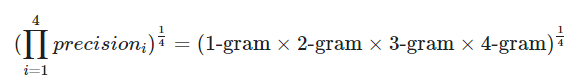

> BLEU Score는 50점을 넘으면 매우 좋은 성능이라 할 수 있으며, 보통 논문에서 제시하는 BLEU Score는 20점에서 높으면 40점의 성능을 보여준다.<br>
> 본 성능 실험에서는 weights의 디폴트 값을 [0.25, 0.25, 0.25, 0.25]으로 설정하여 1-gram부터 4-gram까지의 점수에 가중치를 동일하게 부여한다.

In [55]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference], candidate, weights=weights, smoothing_function=SmoothingFunction().method1)

## 7.2 Beam Search Decoder

> 기존 BLEU Score을 측정하는 <code>Greedy Decoding()</code> 대신 <code>Beam Search</code> 기법을 적용하여 모델 성능 측정 지표를 개선하고자 한다.<br>
>  <br>
>  <code>Beam Size</code>를 5로 설정한 <code>Beam Search Decoder</code>는 아래와 같은 과정을 진행한다.<br>
> 1. 첫 단어로 5개의 단어를 생성하고 두 번째 단어로 각 첫 단어(5개 단어)에 대해 5순위까지 확률을 구하여 총 25개의 문장을 생성한다.<br>
> 2. 25개의 문장들은 각 단어에 할당된 확률을 곱하여 구한 점수(존재 확률) 각각의 순위를 매긴다.<br>
> 3. 점수 상위 5개의 표본만 살아남아 세 번째 단어를 구한다.<br>
> 위 과정을 N-gram의 매 분기마다 반복하면 최종적으로 점수가 가장 높은 5개의 문장을 얻게 된다.<br>

In [52]:
# 각 단어의 확률값 계산 함수
def calc_prob(src_ids, tgt_ids, model):
    enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(
        src_ids, tgt_ids
    )
    
    predictions, enc_attns, dec_attns, dec_enc_attns = model(
        src_ids, tgt_ids, enc_padding_mask, combined_mask, dec_padding_mask
    )
    return tf.math.softmax(predictions, axis=-1)


# Beam Search를 기반으로 동작하는 decoder 함수
def beam_search_decoder(
    sentence, model, tokenizer,
    enc_maxlen, dec_maxlen,
    beam_size
):
    sos_idx = tokenizer.word_index['<start>']
    eos_idx = tokenizer.word_index['<end>']

    tokens = tokenizer.texts_to_sequences([sentence])
    src_in = tf.keras.preprocessing.sequence.pad_sequences(
        tokens,
        maxlen=enc_maxlen,
        padding='post'
    )

    pred_cache = np.zeros((beam_size * beam_size, dec_maxlen), dtype=np.long)
    pred = np.zeros((beam_size, dec_maxlen), dtype=np.long)

    eos_flag = np.zeros((beam_size, ), dtype=np.long)
    scores = np.ones((beam_size, ))

    pred[:, 0] = sos_idx

    dec_in = tf.expand_dims(pred[0, :1], 0)
    prob = calc_prob(src_in, dec_in, model)[0, -1].numpy()
    
    
    for seq_pos in range(1, dec_maxlen):
        score_cache = np.ones((beam_size * beam_size, ))

        # init
        for branch_idx in range(beam_size):
            cache_pos = branch_idx*beam_size

            score_cache[cache_pos:cache_pos+beam_size] = scores[branch_idx]
            pred_cache[cache_pos:cache_pos+beam_size, :seq_pos] = \
            pred[branch_idx, :seq_pos]

        for branch_idx in range(beam_size):
            cache_pos = branch_idx*beam_size

            if seq_pos != 1:   # 모든 Branch를 로 시작하는 경우를 방지
                dec_in = pred_cache[branch_idx, :seq_pos]
                dec_in = tf.expand_dims(dec_in, 0)

                prob = calc_prob(src_in, dec_in, model)[0, -1].numpy()

            for beam_idx in range(beam_size):
                max_idx = np.argmax(prob)

                score_cache[cache_pos+beam_idx] *= prob[max_idx]
                pred_cache[cache_pos+beam_idx, seq_pos] = max_idx

                prob[max_idx] = -1

        for beam_idx in range(beam_size):
            if eos_flag[beam_idx] == -1: continue

            max_idx = np.argmax(score_cache)
            prediction = pred_cache[max_idx, :seq_pos+1]

            pred[beam_idx, :seq_pos+1] = prediction
            scores[beam_idx] = score_cache[max_idx]
            score_cache[max_idx] = -1

            if prediction[-1] == eos_idx:
                eos_flag[beam_idx] = -1
    return pred


# 생성된 문장에 대한 BLEU Score 출력 함수
def beam_bleu(reference, ids, tokenizer, verbose=False):
    reference = reference.split()

    total_score = 0.0
    for _id in ids:
        seq2text = tokenizer.sequences_to_texts([_id])[0]
        _idx =  seq2text.find("<end>")
        seq2text = seq2text[6:_idx]
        candidate = seq2text.split()
        score = calculate_bleu(reference, candidate)
        
        if verbose:
            print("Reference:".ljust(10), " ".join(reference))
            print("Candidate:".ljust(10), " ".join(candidate), end="\n")
            print("BLEU:".ljust(10), f"{calculate_bleu(reference, candidate):.3f}")
        
        total_score += score
        
    return total_score / len(ids)

## 7.3 Transformer Model Test

> 3.5장에서 생성한 100개의 테스트용 문장을 활용하여 훈련된 Transformer model의 성능을 Beam Search Decoder으로 평가한다.

In [54]:
aver_bleu = 0
for _, que, ans in test_data.itertuples():
    ids = beam_search_decoder(
        que,
        transformer, tokenizer,
        enc_tensor.shape[-1], dec_tensor.shape[-1],
        beam_size=5
    )
    
    test_dec_sentence = tokenizer.sequences_to_texts([que])[0]
    _idx = test_dec_sentence.find("<end>")
    test_dec_sentence = test_dec_sentence[6:_idx]
    
    aver_bleu += beam_bleu(test_dec_sentence, ids, tokenizer, verbose=False)
    

print(f" BLEU score: {aver_bleu:.2f}")

 BLEU score: 0.22


> 평가 결과 0.22로, 22의 점수를 기록했으며, 요점은 명확하지만 많은 문법적 오류가 있는 모델이라는 평가를 받았다.<br>
> 이는 보통 논문에서 제시하는 모델의 성능이므로 본 연구에서 훈련된 Transformer model의 성능은 일반적인 성능을 보여준다고 할 수 있다.<br>

> 점수별 상세 내용은 아래 링크를 참고하여 확인할 수 있다.<br>
> [BLEU Score의 점수대별 해석표](https://cloud.google.com/translate/automl/docs/evaluate?hl=ko#bleu)